In [1]:
from google import genai

# The client gets the API key from the environment variable `GEMINI_API_KEY`.
client = genai.Client()

response = client.models.generate_content(
    model="gemini-2.5-flash", contents="Explain how AI works in a few words"
)
print(response.text)

It learns patterns from data to make decisions.


In [2]:
from pathlib import Path

mobs_path = Path.home() / "src/data/mobs1/images"
image_fn = mobs_path / '06092b21-2024-10-20_22.22.09.png'

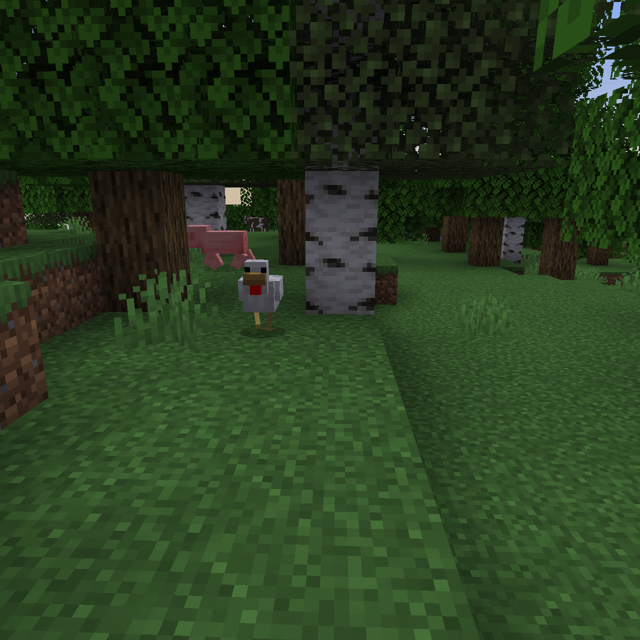

In [7]:
CLASSES = [
    'chicken',
    'cow',
    'creeper',
    'enderman',
    'pig',
    'player',
    'sheep',
    'skeleton',
    'spider',
    'villager',
    'zombie'
    ]
CLASSES.sort()
CLASSES_MINECRAFT = [f"minecraft {x}" for x in CLASSES]

image = Image.open(image_fn)
image = image.resize((image.width // 2, image.height // 2))
display(image)

In [8]:
", ".join(CLASSES)

'chicken, cow, creeper, enderman, pig, player, sheep, skeleton, spider, villager, zombie'

In [ ]:
from google import genai
from google.genai import types
from PIL import Image
import json

client = genai.Client()

prompt = f"""Task: Detect {", ".join(CLASSES)}. Return AT MOST 10 detections.

Output: Return ONLY a valid JSON array (no prose, no code fences). For each detection, emit an object with exactly these keys:
{{
  "box_2d": [ymin, xmin, ymax, xmax],
  "label": "<short, descriptive label>"
}}

Box format rules:
- Coordinates are NORMALIZED to the image on a 0-1000 scale.
  - (ymin, xmin) is the top-left corner of the box.
  - (ymax, xmax) is the bottom-right corner of the box.
  - y increases downward; x increases to the right.
- Numbers must be 0-1000 (floats allowed). If a box would extend outside the image, CLIP to this range.
- Do not include any extra fields.
- If nothing is found, return [].
"""

image = Image.open(image_fn)

config = types.GenerateContentConfig(
  response_mime_type="application/json"
  )

response = client.models.generate_content(model="gemini-2.5-flash",
                                          contents=[image, prompt],
                                          config=config
                                          )

width, height = image.size
bounding_boxes = json.loads(response.text)

converted_bounding_boxes = []
for bounding_box in bounding_boxes:
    abs_y1 = int(bounding_box["box_2d"][0]/1000 * height)
    abs_x1 = int(bounding_box["box_2d"][1]/1000 * width)
    abs_y2 = int(bounding_box["box_2d"][2]/1000 * height)
    abs_x2 = int(bounding_box["box_2d"][3]/1000 * width)
    converted_bounding_boxes.append([abs_x1, abs_y1, abs_x2, abs_y2])

print("Image size: ", width, height)
print("Bounding boxes:", converted_bounding_boxes)


ValueError: Invalid format specifier ' [ymin, xmin, ymax, xmax],
  "label": "<short, descriptive label>"
' for object of type 'str'